# K-Nearest Neighbors

K-Nearest Neighbors (KNN) is a **supervised machine learning algorithm** that can be used for either **regression** or **classification** tasks. It is **non-parametric**, which means that the algorithm does not make assumptions about the underlying distributions of the data. This algorithm is based on **Feature Similarity**. This is in contrast to a technique like linear regression, which is parametric, and requires us to find a function that describes the relationship between dependent and independent variables.

<img src="https://miro.medium.com/max/1080/0*49s1xDlDKDsn55xa.gif" height=90% width=90% style="text-align:center;">

# Minkowski Distance

The distance between points is determined by using a generalized formula, known as Minkowski distance, i.e., represented as follows:

<img src="https://miro.medium.com/max/1000/1*nxGbicBE1MSV4LbBFueJvg.png" height=50% width=50% style="text-align:center;">

*where X and Y are data points, n is the number of dimensions, and p is the Minkowski power parameter.*

When **p=1**, the distance is known at the **Manhattan (or Taxicab) distance**, and when **p=2** the distance is known as the **Euclidean distance**. 

<img src="https://miro.medium.com/max/564/1*nSBd4Q8nA9zo_8iVUHa69w.png" height=35% width=35% style="display:inline;"> <img src="https://miro.medium.com/max/562/1*hUrrJWqXysnlF4zMbNrKVg.png" height=35% width=35% style="display:inline; margin-left:10%; margin-bottom:2%">   
     
In two dimensions, the Manhattan and Euclidean distances between two points are easy to visualize, however at higher orders of p, the Minkowski distance becomes more **abstract**.

# Iris Plant Data Set

The data set has measurements (Sepal Length, Sepal Width, Petal Length, Petal Width) for 150 Iris Plants, split evenly among three species (0 = setosa, 1 = versicolor, and 2 = virginica).

[**Data Set**](http://www.lac.inpe.br/~rafael.santos/Docs/CAP394/WholeStory-Iris.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [2]:
X = df.drop('target', axis=1)
y = df.target

# Building the Model

<h3>Step 1</h3> <b>Defining a function to calculate distance between two points</b>

Here, Taking <b>p = 2, i.e., Euclidean Distance</b> 

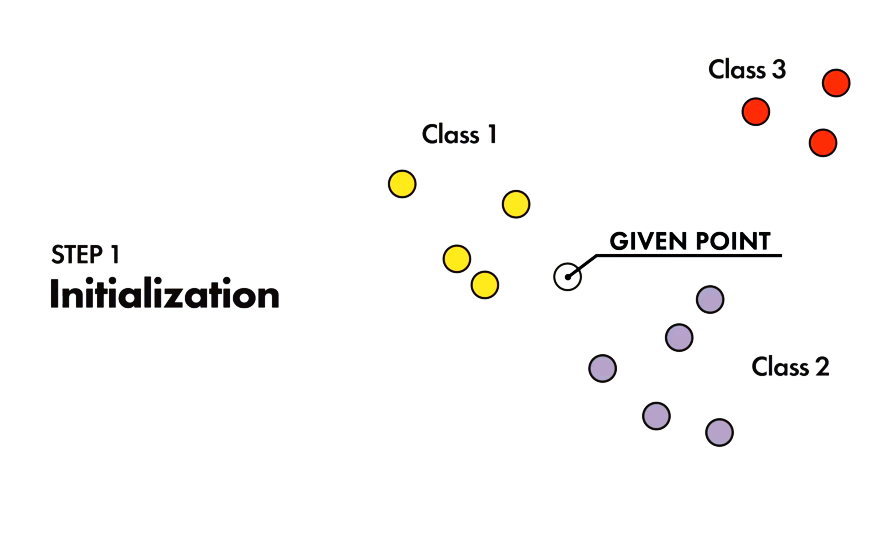

In [3]:
def minkowski_distance(a, b, p=2):
    dim = len(a)                    # Store the number of dimensions
    distance = 0                    # Set initial distance to 0
    for d in range(dim):            # Calculate minkowski distance using parameter p
        distance += abs(a[d] - b[d])**p
        
    distance = distance**(1/p)
    return distance

minkowski_distance(a=X.iloc[0], b=X.iloc[1], p=2)  # Testing the function

0.5385164807134502

<h3>Step 2</h3>

**Using the minkowski_distance() function to get the distance between a test point and all known data points**

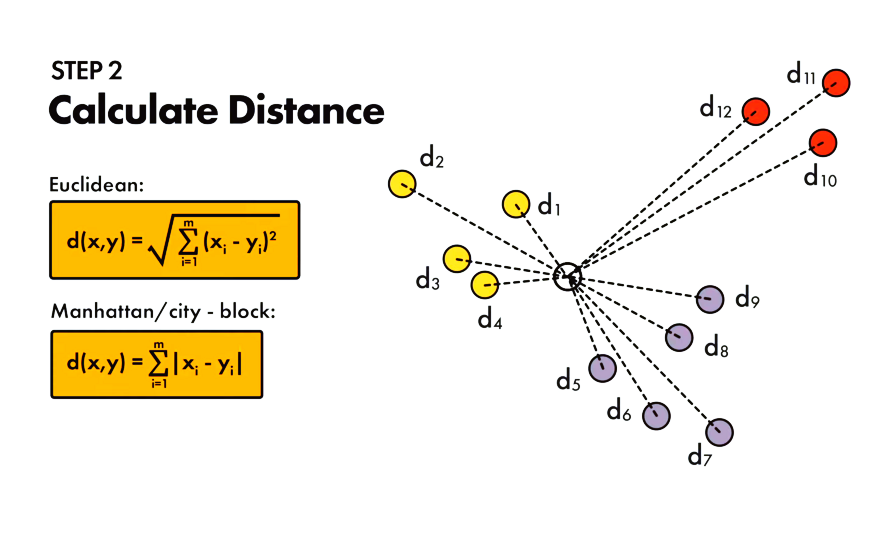

In [4]:
# Defined arbitrary test point
test_pt = [5.2, 2.6, 2.5, 0.8]

# Calculating distance between test_pt and all points in X
distances = []

for i in X.index:
    distances.append(minkowski_distance(test_pt, X.iloc[i]))
    
df_dists = pd.DataFrame(data=distances, index=X.index, columns=['dist'])
df_dists.head()

,dist
0,1.545962
1,1.349074
2,1.552417
3,1.403567
4,1.615549


<h3>Step 3</h3>

**Sort distance measurements to find the points closest to the test point**

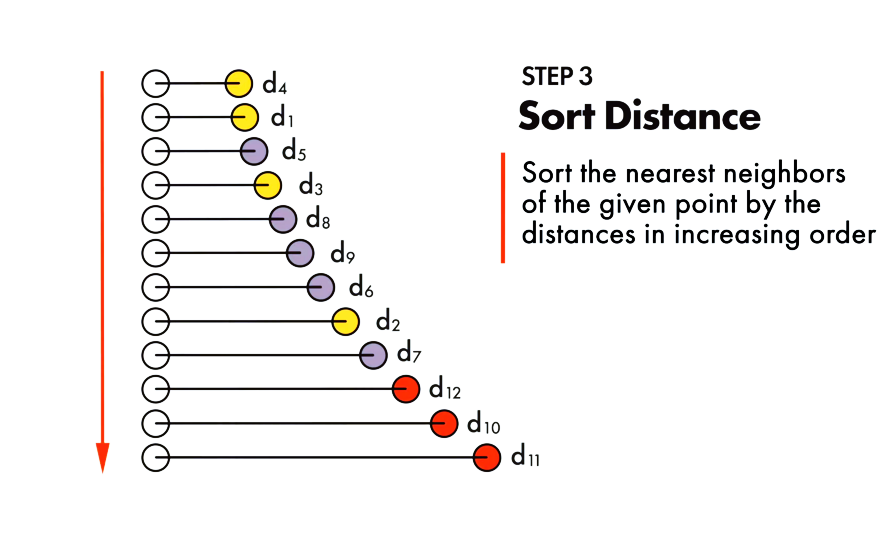

In [5]:
df_nn = df_dists.sort_values(by=['dist'], axis=0)[:5]
df_nn

,dist
98,0.600000
57,0.900000
93,0.900000
23,1.109054
79,1.135782


<h3>Step 4</h3>

**Using majority class labels of those closest points to predict the label of the test point**

Used **collections.Counter** to keep track of the labels that coincide with the nearest neighbor points and then used the **counter.most_common()** to return the most commonly occurring label.

In [6]:
from collections import Counter

counter = Counter(y[df_nn.index])       # Create counter object to track the labels
counter.most_common()[0][0]             # Get most common label of all the nearest neighbors

1

<h3>Step 5</h3>

**Repeat Steps 1 through 4 until all the test data points are classified**

Firstly, perform a **train_test_split** on the data (75% train, 25% test), and then scale the data using **StandardScaler()**. 

Since KNN is distance-based, it is must to make sure that the features are scaled properly before feeding them into the algorithm.

To avoid data leakage, its good to scale the features after the **train_test_split** has been performed. First, scale the data from the training set only (**scaler.fit_transform(X_train)**), and then use that information to scale the test set (**scaler.tranform(X_test)**). 

This ensures that no information outside of the training data is used to create the model.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data - 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

scaler = StandardScaler()                    # Scaling the X data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN Prediction Function

Function takes in all of the training and test data, k, and p, and returns the predictions my KNN classifier makes for the test set (**y_hat_test**). 

The function should return a list of label predictions containing only 0’s, 1’s and 2’s.

In [8]:
def knn_prediction(X_train, X_test, y_train, y_test, k, p):
    
    # Counter to help with label voting
    from collections import Counter
    
    # Make predictions on the test data
    # Need output of 1 prediction per test data point
    y_hat_test = []
    
    for test_point in X_test:
        distances = []
        
        for train_point in X_train:
            distance = minkowski_distance(test_point, train_point, p=p)
            distances.append(distance)
        
        # Store distances in a dataframe
        df_dists = pd.DataFrame(data=distances, columns=['dist'], index=y_train.index)
        
        # Sort distances, and only consider the k closest points
        df_nn = df_dists.sort_values(by=['dist'], axis=0)[:k]

        # Create counter object to track the labels of k closest neighbors
        counter = Counter(y_train[df_nn.index])

        # Get most common label of all the nearest neighbors
        prediction = counter.most_common()[0][0]
        
        # Append prediction to output list
        y_hat_test.append(prediction)
        
    return y_hat_test

# Making predictions on test dataset
y_hat_test = knn_prediction(X_train, X_test, y_train, y_test, k=5, p=2)

print(y_hat_test)

[0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0]


# Accuracy

In [9]:
# Getting test accuracy score
from sklearn.metrics import accuracy_score

print(f"My KNN Model's Accuracy: {accuracy_score(y_test, y_hat_test)}")

My KNN Model's Accuracy: 0.9736842105263158


In [10]:
# Testing to see results from sklearn.neighbors.KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, p=2)  # k = 5
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print(f"Sklearn KNN Accuracy: {accuracy_score(y_test, y_pred_test)}")

Sklearn KNN Accuracy: 0.9736842105263158


<h3> Both the accuracies are exactly the same !! </h3>

# Effect of Varying K

KNN doesn’t have as many tune-able parameters as other algorithms like Decision Trees or Random Forests, but k happens to be one of them. 

The Predication changes by variation in 'K' value.

Observing the classification accuracy variation with the varying 'k' value:

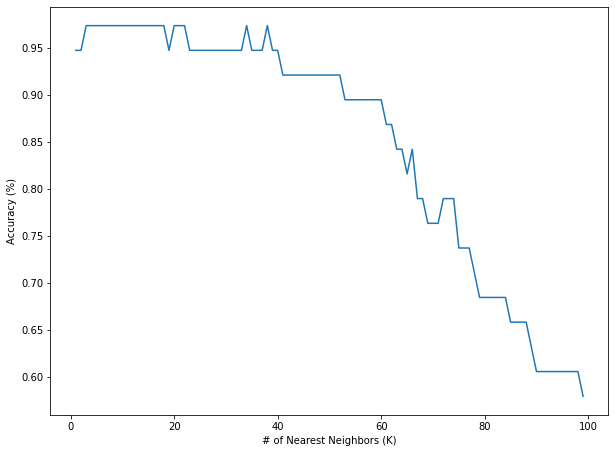

In [11]:
accuracies = []
for k in range(1,100):
    y_hat_test = knn_prediction(X_train, X_test, y_train, y_test, k, p=1)
    accuracies.append(accuracy_score(y_test, y_hat_test))

# Plot the results 
fig, ax = plt.subplots(figsize=(10,7.5))
ax.plot(range(1,100), accuracies)
ax.set_xlabel('# of Nearest Neighbors (K)')
ax.set_ylabel('Accuracy (%)');

# Real World Applications

<h3> Anomaly/Outlier Detection & Fraud Detection </h3>

<img src="https://raw.githubusercontent.com/DHI/tsod/main/images/anomaly.png" height=50% width=50% style="display:inline;">   <img src="https://resources.cdn.seon.io/uploads/2021/02/Fraud_Detection_Prevention_02_03_isolated.png" height=40% width=40% style="display:inline;">  

<h3> Recommendation Systems </h3>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/YouTube_full-color_icon_%282017%29.svg/800px-YouTube_full-color_icon_%282017%29.svg.png" height=14% width=14% style="display:inline;">   <img src="https://1000logos.net/wp-content/uploads/2021/04/Spotify-logo.png" height=15% width=15% style="display:inline;">   <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Amazon_icon.svg/2500px-Amazon_icon.svg.png" height=10% width=10% style="display:inline;">   <img src="https://1000logos.net/wp-content/uploads/2017/05/Netflix-Logo-2006.png" height=15% width=15% style="display:inline;">   <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Instagram_logo_2016.svg/2048px-Instagram_logo_2016.svg.png" height=10% width=10% style="display:inline;">

<h3> Facial Recognition & Stock Predication </h3>

<img src="https://venturebeat.com/wp-content/uploads/2021/06/GettyImages-1195209545.jpg?fit=1732%2C891&strip=all" height=40% width=40% style="display:inline;">  <img src="https://static8.depositphotos.com/1029110/1066/v/600/depositphotos_10667623-stock-illustration-office-worker-and-presentation.jpg" height=40% width=40% style="display:inline;">

<h3> Health Care, Transportation, Agriculture, etc. </h3>

<img src="https://static-www.elastic.co/v3/assets/bltefdd0b53724fa2ce/blta401f2e7dad39503/620d844d9d54947c7f131b0a/illustration-industry-health.png" height=40% width=40% style="display:inline;">  <img src="https://kstatic.googleusercontent.com/files/a53d419918a354a5726d7e68cfa9c7aee0e1673f34ffa8463aa5c3808ef08458331048d0fce44529ade545f4c0a2687280a4fd8cb0c989a572a0ed1ddaed82bb" height=15% width=15% style="display:inline;">

# Conlcusion

* KNN is most useful when labeled data is too expensive or impossible to obtain, and it can achieve high accuracy in a wide variety of prediction-type problems.

* It works on **low dimensional data** set while faces problems when dealing with high dimensional data.


<img src="https://www.edureka.co/blog/wp-content/uploads/2019/03/Features-of-KNN-KNN-Algorithm-In-R-Edureka.png" height=90% width=90% style="text-align:center;">